<a href="https://colab.research.google.com/github/solankiharsh/sorting_hat_classification/blob/main/SortingHatClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sorting Hat (Harry Potter)

In [51]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
df_train = pd.read_csv('dataset_train.csv')
df_test = pd.read_csv('dataset_test.csv')

In [32]:
df_train.head()

Index Hogwarts House  ...     Charms  Flying
0      0      Ravenclaw  ... -232.79405  -26.89
1      1      Slytherin  ... -252.18425 -113.45
2      2      Ravenclaw  ... -227.34265   30.42
3      3     Gryffindor  ... -256.84675  200.64
4      4     Gryffindor  ... -256.38730  157.98

[5 rows x 19 columns]

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Index                          1600 non-null   int64  
 1   Hogwarts House                 1600 non-null   object 
 2   First Name                     1600 non-null   object 
 3   Last Name                      1600 non-null   object 
 4   Birthday                       1600 non-null   object 
 5   Best Hand                      1600 non-null   object 
 6   Arithmancy                     1566 non-null   float64
 7   Astronomy                      1568 non-null   float64
 8   Herbology                      1567 non-null   float64
 9   Defense Against the Dark Arts  1569 non-null   float64
 10  Divination                     1561 non-null   float64
 11  Muggle Studies                 1565 non-null   float64
 12  Ancient Runes                  1565 non-null   f

In [53]:
df_test.head()

Index  Hogwarts House  ...     Charms  Flying
0      0             NaN  ... -244.48172  -13.62
1      1             NaN  ... -231.29200  -26.26
2      2             NaN  ... -252.99343  200.15
3      3             NaN  ... -244.01660  -11.15
4      4             NaN  ... -243.99806   -7.12

[5 rows x 19 columns]

In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Index                          400 non-null    int64  
 1   Hogwarts House                 0 non-null      float64
 2   First Name                     400 non-null    object 
 3   Last Name                      400 non-null    object 
 4   Birthday                       400 non-null    object 
 5   Best Hand                      400 non-null    object 
 6   Arithmancy                     387 non-null    float64
 7   Astronomy                      387 non-null    float64
 8   Herbology                      389 non-null    float64
 9   Defense Against the Dark Arts  392 non-null    float64
 10  Divination                     394 non-null    float64
 11  Muggle Studies                 390 non-null    float64
 12  Ancient Runes                  392 non-null    flo

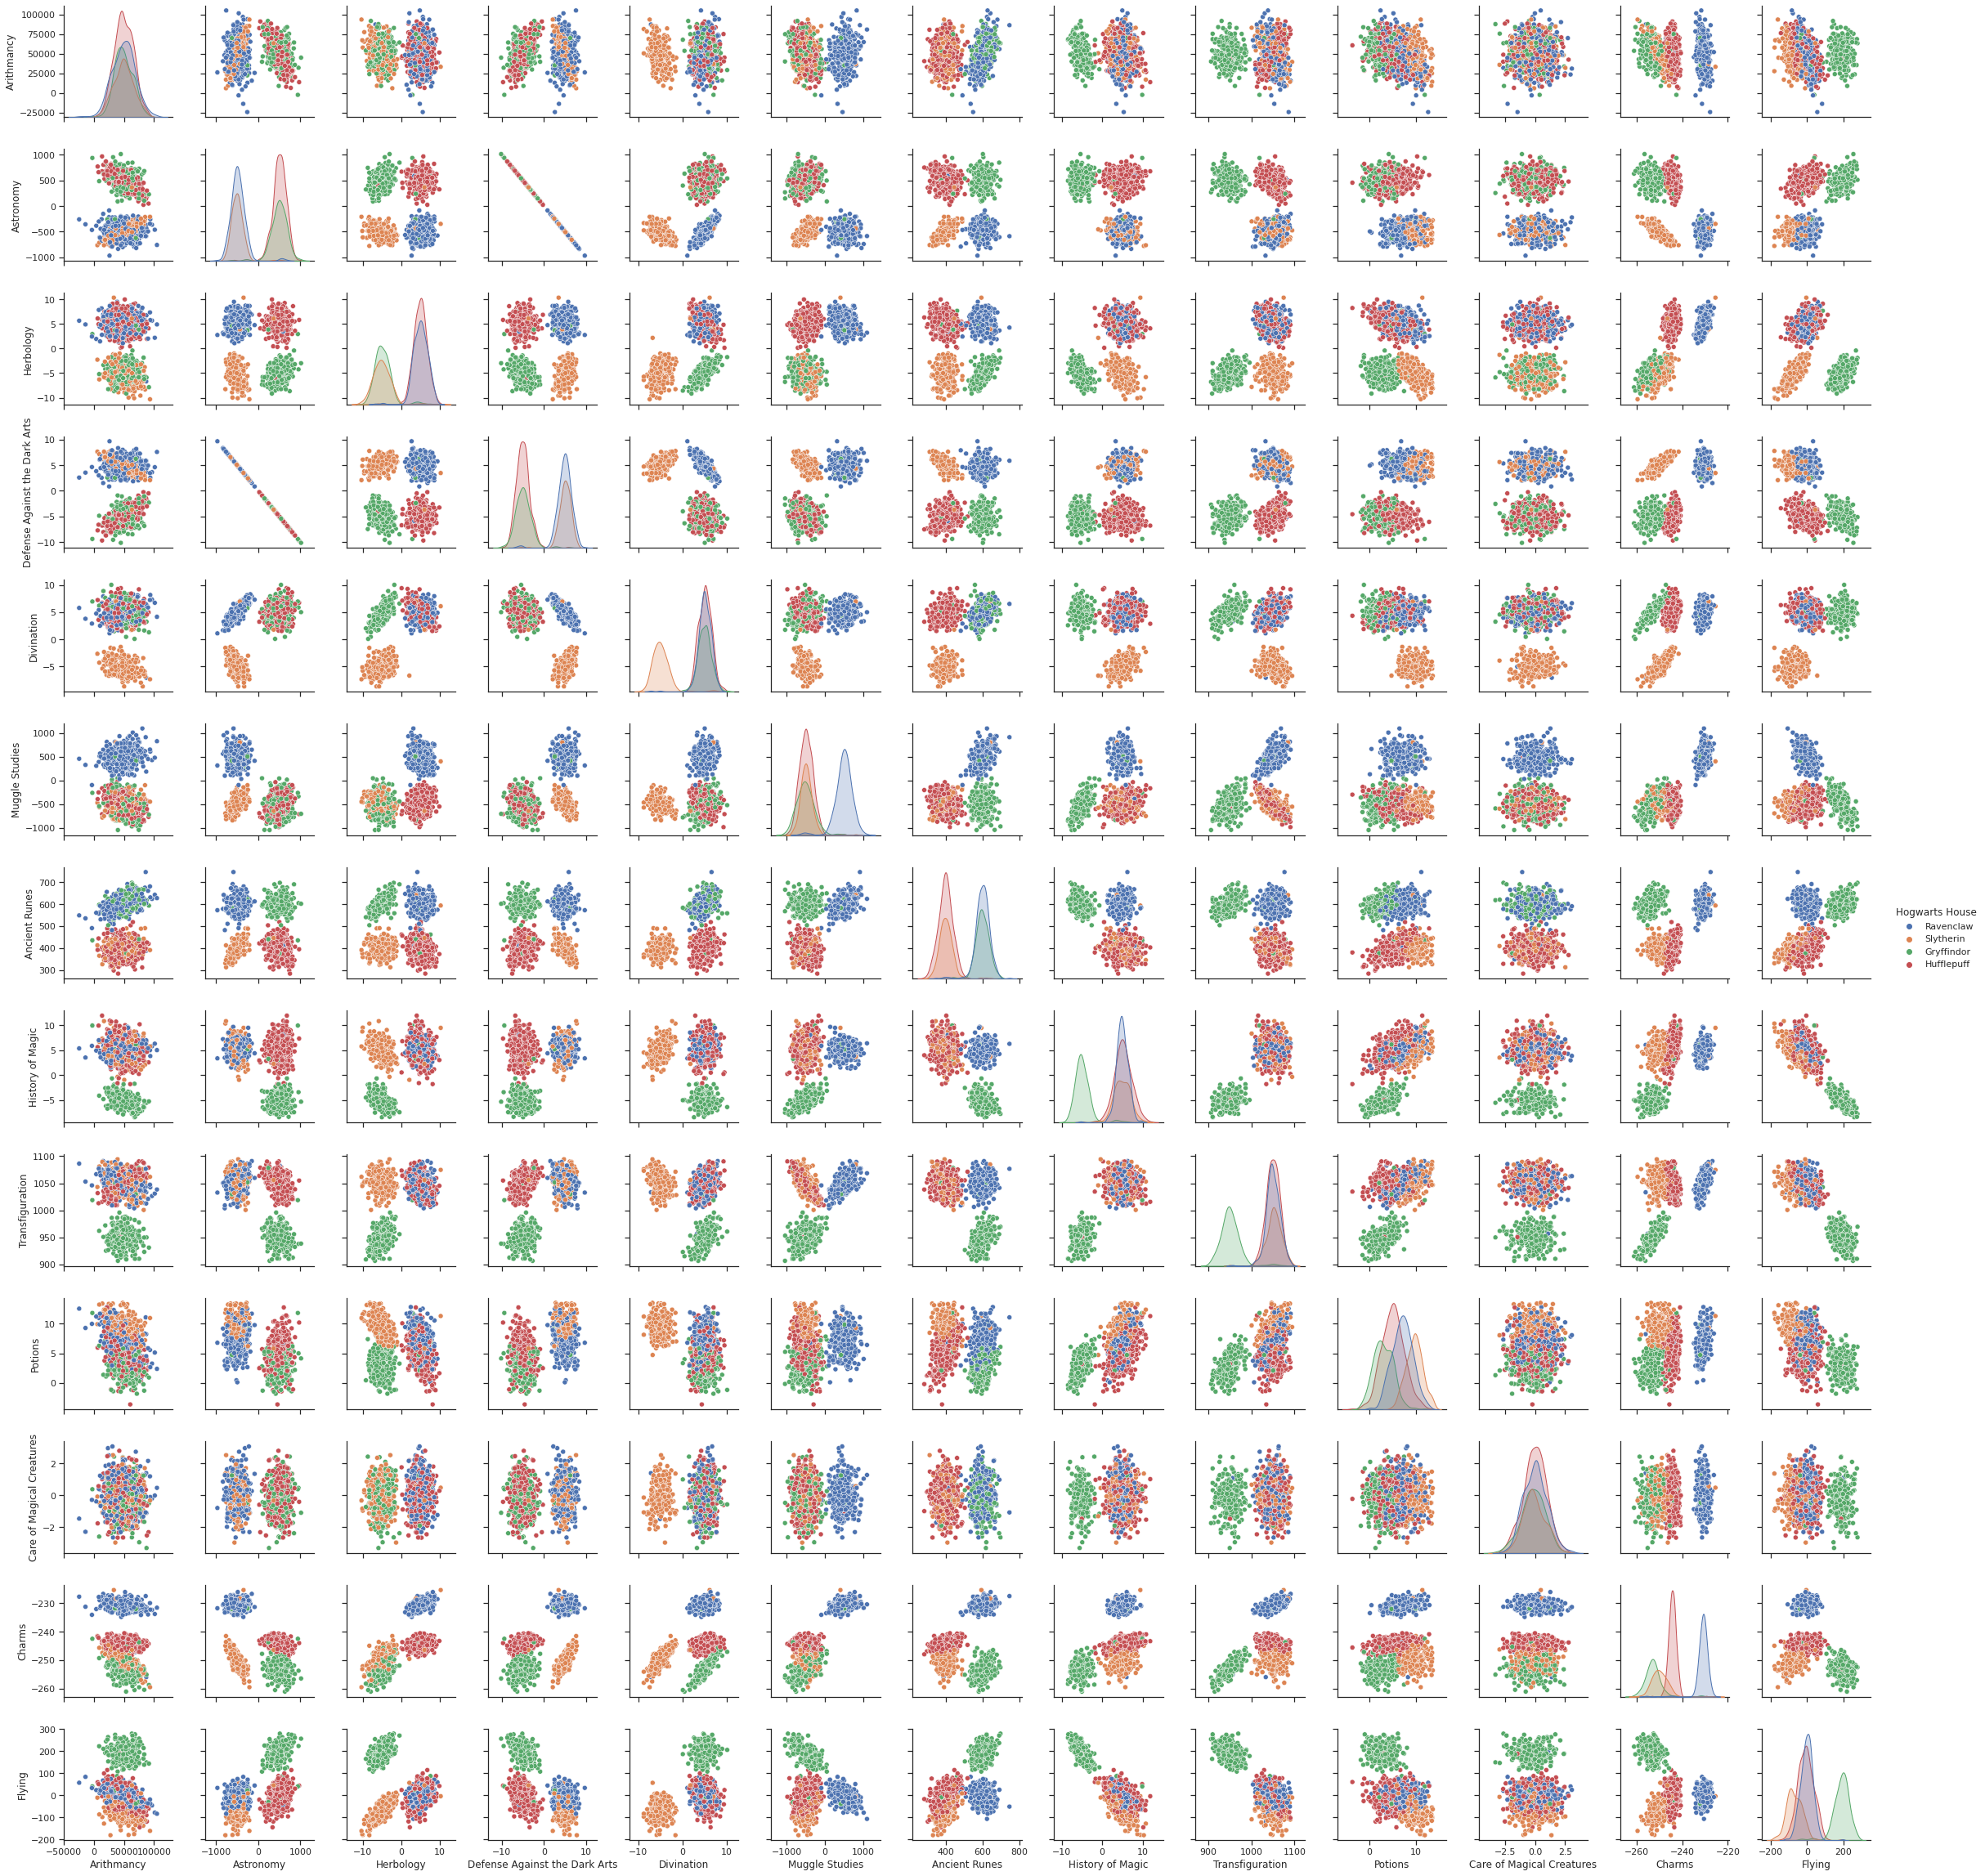

In [34]:
sns.set(style="ticks", color_codes=True)

df_viz = df_train.dropna()
# dropping the index because it does not make any sense to do a scatter pair plot on
df_viz = df_viz.drop("Index", axis=1)
g = sns.pairplot(df_viz, hue="Hogwarts House")
g.savefig('pairplot.png')

- So here we look at the pair plot and see what variables are useful to group people by. There is no use to use all features as some of them don't provide an obvious division into groups and can bring only noise. So far as we are looking for four clearly different groups, there Astrology, Herbology, Defense Against the Dark Arts, Ancient runes, Charms ish, Flying.

- Two features - Defense Against the Dark Arts and Astronomy- are interesting and at first glance they look quite similar. Let's take a look at them.

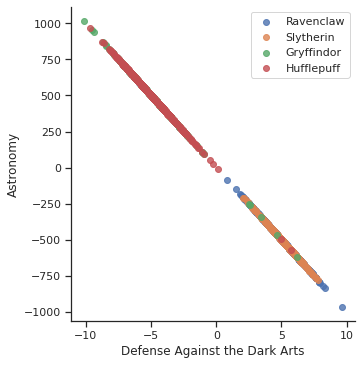

In [35]:
sns.lmplot(x="Defense Against the Dark Arts", 
           y="Astronomy", 
           data=df_train, 
           fit_reg=False, 
           hue='Hogwarts House', 
           legend=False)

plt.legend(loc='upper right')

In [36]:
df_train['Astronomy'] / df_train['Defense Against the Dark Arts']

0      -100.0
1      -100.0
2      -100.0
3      -100.0
4         NaN
        ...  
1595   -100.0
1596   -100.0
1597   -100.0
1598   -100.0
1599   -100.0
Length: 1600, dtype: float64

In [55]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def standartize(df, names):
    tmp = df.copy()
    df = tmp[names]
    # Create the Scaler object
    scaler = preprocessing.StandardScaler()
    # Fit your data on the scaler object
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    return scaled_df, scaler

def preprocess_df(df):
    df = df.copy()
    # drop useless columns
    df = df.drop(columns=['Index', 'First Name', 'Last Name', 'Astronomy'])
    # fill missing values in features with mean
    df = df.fillna(df.mean())        
    # preprocess columns
    # convert categorical features to numerical
    df['Best Hand'] = df['Best Hand'].astype('category')
    df['Hogwarts House'] = df['Hogwarts House'].astype('category')
    # store mapping for later usage
    map_dict = dict(enumerate(df['Best Hand'].cat.categories)), dict(enumerate(df['Hogwarts House'].cat.categories))
    df['Best Hand'] = df['Best Hand'].cat.codes
    df['Hogwarts House'] = df['Hogwarts House'].cat.codes
    # convert string date to datetime
    df['Birthday'] = pd.to_datetime(df['Birthday'])
    # separate datetime into day, month, year features
    df['Birth_day'] = df['Birthday'].dt.day
    df['Birth_month'] = df['Birthday'].dt.month
    df['Birth_year'] = df['Birthday'].dt.year
    df = df.drop(columns=['Birthday'])
    
    X = df.drop(columns=['Hogwarts House'])
    y = df['Hogwarts House']
    
    # get train and val split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  
    transformed_features = list(set(X_train.columns) - set(['Best Hand']))
    
    train_indxs = X_train.index
    test_indxs = X_test.index
    
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # standartize train
    X_train_scaled, scaler = standartize(X_train, transformed_features)
    X_train_scaled['Best Hand'] = X_train['Best Hand']
    
    # standartize test
    X_test_scaled = scaler.fit_transform(X_test[transformed_features])
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=transformed_features)
    X_test_scaled['Best Hand'] = X_test['Best Hand']
    
    preprocessing_params = {'map_dict': map_dict,
                            'scaler': scaler,
                            'train_indxs':train_indxs,
                            'test_indxs':test_indxs}
    
    return X_train_scaled, X_test_scaled, y_train, y_test, preprocessing_params

In [56]:
X_train, X_test, y_train, y_test, processing_params = preprocess_df(df_train)

In [57]:
X_train.head()

Ancient Runes  Care of Magical Creatures  ...  Birth_day  Best Hand
0      -0.589052                   0.437238  ...  -1.437774          0
1       0.928244                   0.463269  ...  -1.437774          1
2       0.941062                  -0.641019  ...  -0.980620          1
3      -1.525900                  -0.648676  ...   0.619418          1
4       0.392511                   1.267019  ...   0.390841          1

[5 rows x 16 columns]

In [58]:
processing_params

{'map_dict': ({0: 'Left', 1: 'Right'},
  {0: 'Gryffindor', 1: 'Hufflepuff', 2: 'Ravenclaw', 3: 'Slytherin'}),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'test_indxs': Int64Index([ 526,  354,  168,  135,  937, 1544, 1253,  237,  478,  650,
             ...
              915, 1467,  296, 1483,  461, 1593,  785,  377, 1471,  126],
            dtype='int64', length=528),
 'train_indxs': Int64Index([ 820,  567,  355, 1545,  209,  140, 1488, 1120, 1047, 1446,
             ...
             1238,  466,  121, 1044, 1095, 1130, 1294,  860, 1459, 1126],
            dtype='int64', length=1072)}

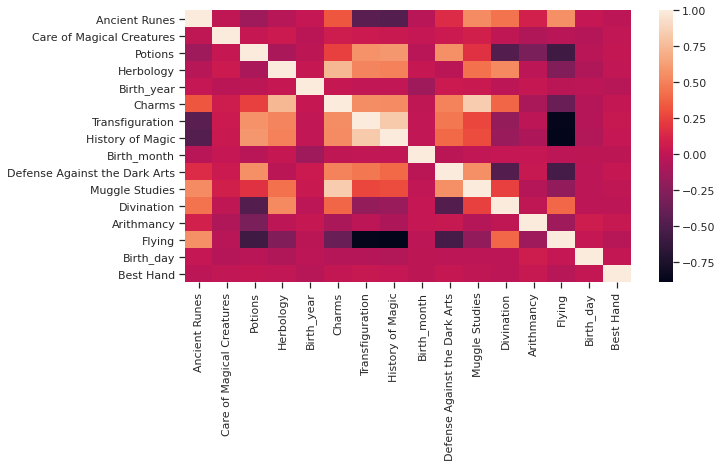

In [59]:
plt.figure(figsize=(10,5))
sns.heatmap(X_train.corr())

In [60]:
def df_to_numpyarray(X, y):
    # Extract input & outupts as numpy arrays
    inputs_array = X.to_numpy()
    targets_array = y.to_numpy()
    return inputs_array, targets_array

In [61]:
X_train, y_train = df_to_numpyarray(X_train, y_train)
X_test, y_test = df_to_numpyarray(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1072, 16) (1072,)
(528, 16) (528,)


In [62]:
tmp = X_test.copy()
X_test = tmp[:int(len(tmp)*0.5)]
X_val = tmp[int(len(tmp)*0.5):]

tmp = y_test.copy()
y_test = tmp.copy()[:int(len(tmp)*0.5)]
y_val = tmp.copy()[int(len(tmp)*0.5):]

X_test.shape, X_val.shape

((264, 16), (264, 16))

In [63]:
# Hyperparmeters
batch_size = 64
learning_rate = 1e-3

# Other constants
input_size = 16
num_classes = 4

In [64]:
import torch
# convert numpy arrays to Tensors
train_inputs = torch.from_numpy(X_train).float()
train_targets = torch.from_numpy(y_train).type(torch.LongTensor)

val_inputs = torch.from_numpy(X_val).float()
val_targets = torch.from_numpy(y_val).type(torch.LongTensor)

test_inputs = torch.from_numpy(X_test).float()
test_targets = torch.from_numpy(y_test).type(torch.LongTensor)

In [65]:
train_inputs, val_inputs, test_inputs, train_targets, val_targets, test_targets

(tensor([[-0.5891,  0.4372,  1.8485,  ...,  0.1582, -1.4378,  0.0000],
         [ 0.9282,  0.4633,  0.5867,  ..., -0.1779, -1.4378,  1.0000],
         [ 0.9411, -0.6410, -1.0438,  ...,  2.0649, -0.9806,  1.0000],
         ...,
         [ 1.7305, -1.1839, -0.4124,  ...,  2.2543,  1.7623,  1.0000],
         [-0.8353,  0.8483, -0.0588,  ...,  0.0849, -0.6378,  0.0000],
         [-1.0657, -0.0282,  2.0092,  ..., -0.9606,  0.2766,  1.0000]]),
 tensor([[-0.1829,  0.0050,  0.4760,  ..., -0.3007, -1.3026,  1.0000],
         [-0.5417,  1.0719, -0.0927,  ..., -0.6557, -0.4976,  1.0000],
         [-0.8052, -0.8057,  1.7394,  ..., -0.7212,  0.6523,  0.0000],
         ...,
         [-0.9673, -1.8157,  0.0591,  ...,  0.4357, -0.2677,  0.0000],
         [-1.1014,  0.1622,  0.5984,  ..., -0.7525,  1.4572,  0.0000],
         [-0.1216, -0.6745,  0.2282,  ...,  0.4028,  0.3073,  1.0000]]),
 tensor([[ 1.1236,  1.4048, -0.8102,  ...,  1.4244, -1.1876,  1.0000],
         [-1.0071,  0.1161, -1.1946,  ..., -0

In [66]:
[s.shape for s in [train_inputs, val_inputs, test_inputs, train_targets, val_targets, test_targets]]

[torch.Size([1072, 16]),
 torch.Size([264, 16]),
 torch.Size([264, 16]),
 torch.Size([1072]),
 torch.Size([264]),
 torch.Size([264])]

In [67]:
# Dataset
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

In [68]:
item, label = train_dataset[120]
print(item, label)

tensor([ 1.0304e+00, -7.6630e-01,  5.1026e-01,  1.2128e+00,  8.2379e-01,
         1.5868e+00,  3.8875e-01,  1.1845e+00,  7.3554e-01,  7.3246e-01,
         3.1140e-04,  7.2260e-01,  8.4221e-01, -5.8556e-01,  4.7976e-02,
         1.0000e+00]) tensor(2)


In [69]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[-0.7397, -0.1185,  1.5897,  ..., -0.7130,  0.9623,  0.0000],
        [-0.6683,  0.0979, -0.2020,  ...,  0.4030, -1.0949,  1.0000],
        [ 0.8013, -0.1442, -0.0577,  ..., -0.0590,  1.5337,  1.0000],
        ...,
        [ 0.8808, -0.9547, -0.9818,  ...,  1.9522,  1.5337,  1.0000],
        [-1.2348, -1.2941,  2.2741,  ..., -1.3594,  1.5337,  0.0000],
        [ 1.2341, -1.2335, -0.2298,  ...,  2.1781, -0.1806,  1.0000]])
targets: tensor([3, 1, 2, 2, 1, 2, 0, 1, 2, 2, 0, 3, 1, 0, 1, 0, 2, 3, 2, 2, 1, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 0, 3, 0, 1, 0, 2, 1, 1, 2, 3, 1, 1,
        0, 1, 3, 1, 2, 1, 1, 3, 0, 1, 0, 0, 0, 0, 3, 0])


In [72]:
class SortingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.cross_entropy(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.cross_entropy(out, targets)   # Calculate loss
        acc = accuracy(out, targets)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [73]:
model = SortingModel()

In [74]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [75]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [76]:
evaluate(model, val_loader),\
evaluate(model, test_loader)

({'val_acc': 0.1979166716337204, 'val_loss': 1.4652742147445679},
 {'val_acc': 0.2604166567325592, 'val_loss': 1.3346452713012695})

In [77]:
%%time
history = fit(200, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4382, val_acc: 0.2083
Epoch [1], val_loss: 1.4118, val_acc: 0.2109
Epoch [2], val_loss: 1.3861, val_acc: 0.2188
Epoch [3], val_loss: 1.3609, val_acc: 0.2995
Epoch [4], val_loss: 1.3365, val_acc: 0.3151
Epoch [5], val_loss: 1.3126, val_acc: 0.3385
Epoch [6], val_loss: 1.2894, val_acc: 0.3464
Epoch [7], val_loss: 1.2668, val_acc: 0.3516
Epoch [8], val_loss: 1.2448, val_acc: 0.3646
Epoch [9], val_loss: 1.2233, val_acc: 0.3828
Epoch [10], val_loss: 1.2024, val_acc: 0.3958
Epoch [11], val_loss: 1.1820, val_acc: 0.4062
Epoch [12], val_loss: 1.1621, val_acc: 0.4141
Epoch [13], val_loss: 1.1427, val_acc: 0.4245
Epoch [14], val_loss: 1.1238, val_acc: 0.4349
Epoch [15], val_loss: 1.1054, val_acc: 0.4479
Epoch [16], val_loss: 1.0874, val_acc: 0.4557
Epoch [17], val_loss: 1.0699, val_acc: 0.4714
Epoch [18], val_loss: 1.0528, val_acc: 0.4792
Epoch [19], val_loss: 1.0361, val_acc: 0.4948
Epoch [20], val_loss: 1.0198, val_acc: 0.5417
Epoch [21], val_loss: 1.0039, val_acc: 0.544

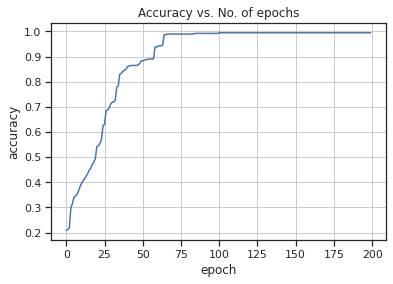

In [78]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

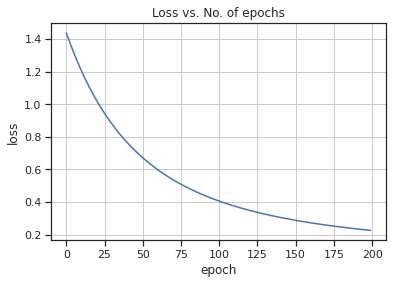

In [79]:
accuracies = [r['val_loss'] for r in history]
plt.plot(accuracies)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [80]:
# Evaluate on val dataset
result = evaluate(model, val_loader)
result

{'val_acc': 0.9947916865348816, 'val_loss': 0.2265065759420395}

In [81]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.9895833134651184, 'val_loss': 0.203647181391716}

In [82]:
df_train.iloc[processing_params['test_indxs'][int(len(processing_params['test_indxs'])*0.5):]][['Hogwarts House', 'First Name', 'Last Name']]

Hogwarts House First Name Last Name
1093     Hufflepuff      Terri    Spring
582      Hufflepuff      Bryce      Epps
787       Slytherin   Carmella     Brice
1214     Hufflepuff    Donnell   Hammons
128       Slytherin     Wilbur  Burnside
...             ...        ...       ...
1593      Ravenclaw    Adeline    Church
785      Hufflepuff       Asia   Bledsoe
377      Hufflepuff     Armand   Bolling
1471     Hufflepuff    Katrina    Burley
126      Hufflepuff     Amanda     Anaya

[264 rows x 3 columns]

In [83]:
testing_indexes = df_train.iloc[processing_params['test_indxs'][int(len(processing_params['test_indxs'])*0.5):]][['Hogwarts House', 'First Name', 'Last Name']].index
testing_indexes = {index:num for num, index in enumerate(testing_indexes)}
testing_indexes

{18: 172,
 31: 180,
 48: 203,
 54: 156,
 58: 83,
 63: 36,
 81: 104,
 83: 200,
 86: 148,
 111: 108,
 113: 164,
 126: 263,
 128: 4,
 147: 197,
 155: 205,
 163: 26,
 174: 167,
 179: 214,
 181: 251,
 188: 193,
 192: 34,
 196: 101,
 208: 79,
 210: 182,
 214: 186,
 218: 45,
 221: 163,
 231: 23,
 233: 99,
 236: 73,
 243: 236,
 254: 137,
 265: 152,
 266: 28,
 277: 69,
 285: 175,
 286: 47,
 287: 153,
 292: 94,
 296: 256,
 308: 246,
 310: 116,
 312: 242,
 322: 138,
 326: 190,
 327: 136,
 341: 195,
 346: 226,
 358: 155,
 360: 199,
 363: 221,
 365: 151,
 370: 249,
 371: 14,
 377: 261,
 383: 53,
 411: 20,
 420: 147,
 422: 127,
 423: 173,
 425: 5,
 426: 223,
 427: 92,
 428: 176,
 429: 25,
 430: 248,
 433: 123,
 435: 243,
 439: 183,
 450: 82,
 453: 170,
 461: 258,
 479: 202,
 481: 18,
 482: 118,
 486: 106,
 490: 62,
 494: 144,
 495: 84,
 497: 60,
 500: 10,
 506: 140,
 513: 168,
 522: 12,
 532: 229,
 538: 253,
 543: 16,
 548: 35,
 552: 95,
 582: 1,
 583: 126,
 589: 50,
 596: 160,
 599: 169,
 602: 119,

In [84]:
def get_prediction(dataset, model, index, mapping):
    input, target = dataset[index]
    predict_single(input, target, model, mapping)

def predict_single(input, target, model, mapping):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    _, predictions  = torch.max(predictions, dim=1)
    prediction = predictions[0].detach()
    print("Target:", mapping[target.item()])
    print("Prediction:", mapping[prediction.item()])

In [85]:
import random

for id_ in [random.choice(list(testing_indexes.keys())) for _ in range(10)]:
    get_prediction(test_dataset, model, testing_indexes[id_], processing_params['map_dict'][1])
    print('---')

Target: Ravenclaw
Prediction: Ravenclaw
---
Target: Ravenclaw
Prediction: Ravenclaw
---
Target: Hufflepuff
Prediction: Hufflepuff
---
Target: Hufflepuff
Prediction: Hufflepuff
---
Target: Slytherin
Prediction: Slytherin
---
Target: Ravenclaw
Prediction: Ravenclaw
---
Target: Slytherin
Prediction: Slytherin
---
Target: Hufflepuff
Prediction: Hufflepuff
---
Target: Hufflepuff
Prediction: Hufflepuff
---
Target: Ravenclaw
Prediction: Ravenclaw
---


In [86]:
torch.save(model.state_dict(), 'hogwarts-logistic.pth')